In [1]:
# script to save the rankings for the mechanism
import os
import sys
import copy
import pickle
import pandas as pd

import numpy as np
import rmgpy.chemkin
import cantera as ct

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/work/westgroup/harris.se/autoscience/reaction_calculator/dft')
import importlib
import thermokinetic_fun
importlib.reload(thermokinetic_fun)

<module 'thermokinetic_fun' from '/work/westgroup/harris.se/autoscience/reaction_calculator/dft/thermokinetic_fun.py'>

## Load the model for reaction and species descriptions

In [2]:
basedir = '/work/westgroup/harris.se/autoscience/reaction_calculator/delay_uncertainty/base_rmg_1week'

cantera_file = os.path.join(basedir, 'chem_annotated.cti')
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport, use_chemkin_names=True)

gas = ct.Solution(cantera_file)
perturbed_cti_path = os.path.join(basedir, 'perturbed.cti')
perturbed_gas = ct.Solution(perturbed_cti_path)

# This cti -> rmg converter dictionary can be made using rmg_tools/ct2rmg_dict.py
with open(os.path.join(basedir, 'ct2rmg_rxn.pickle'), 'rb') as handle:
    ct2rmg_rxn = pickle.load(handle)

print(f'{len(species_list)} species loaded')
print(f'{len(reaction_list)} reactions loaded')

For species Ar, discontinuity in h/RT detected at Tmid = 4762.74
	Value computed using low-temperature polynomial:  2.327935178063383
	Value computed using high-temperature polynomial: 2.320328165487312

For species He, discontinuity in h/RT detected at Tmid = 4762.74
	Value computed using low-temperature polynomial:  2.327935178063383
	Value computed using high-temperature polynomial: 2.320328165487312

For species butane(1), discontinuity in h/RT detected at Tmid = 1389.0
	Value computed using low-temperature polynomial:  6.672352745666894
	Value computed using high-temperature polynomial: 6.314788936675075

For species CH(3), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  81.27192833333334
	Value computed using high-temperature polynomial: 81.30542726833333

For species C2H(4), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  79.04515833333333
	Value computed using high-temperature 

130 species loaded
2488 reactions loaded


In [3]:
N = len(gas.species())
M = len(gas.reactions())

In [4]:
# check for outliers that get crushed by average

In [179]:
M

2523

## Gather Uncertainty Rankings

In [5]:
# rxn_uncertainty_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/reaction_uncertainty.npy'
# sp_uncertainty_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/species_uncertainty.npy'

rxn_uncertainty_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/gao_reaction_uncertainty.npy'
sp_uncertainty_file = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/gao_species_uncertainty.npy'

rmg_rxn_uncertainty = np.load(rxn_uncertainty_file)
rmg_sp_uncertainty = np.load(sp_uncertainty_file)

assert len(rmg_rxn_uncertainty) == len(reaction_list)
assert len(rmg_sp_uncertainty) == len(species_list)


rxn_uncertainty = np.zeros(len(gas.reactions()))
for ct_index in range(len(rxn_uncertainty)):
    rxn_uncertainty[ct_index] = rmg_rxn_uncertainty[ct2rmg_rxn[ct_index]]

# Cantera species should be in same rmg order, but this makes sure for us
for i in range(len(species_list)):
    assert str(species_list[i]) == gas.species_names[i]

sp_uncertainty = rmg_sp_uncertainty

total_uncertainty_array = np.concatenate((sp_uncertainty, rxn_uncertainty), axis=0)
total_uncertainty_mat = np.repeat(np.transpose(np.matrix(total_uncertainty_array)), 12 * 51, axis=1)


In [6]:

# Display the most uncertain parameters

In [7]:
# Calculate Improvement Score
DFT_error = 3.0
# improvement_score = np.abs(reaction_sensitivities) * (uncorrelated_uncertainties - DFT_error)
# improvement_score_order = [x for _,x in sorted(zip(improvement_score, reaction_indices))][::-1]
reaction_indices = np.arange(0, len(gas.reactions()))
reaction_uncertainty_order = [x for _,x in sorted(zip(rxn_uncertainty, reaction_indices))][::-1]

In [8]:
print('Top Uncertain Reactions')
print('i\tDelta\tReaction\tSensitivity\tImprovement Score')
for i in range(0, 50):
    ct_index = reaction_uncertainty_order[i]
    print(ct_index, '\t', np.round(rxn_uncertainty[ct_index], 3),
          '\t', gas.reactions()[ct_index], 
          '\t', reaction_list[ct2rmg_rxn[ct_index]].family)
#           '\t', f'{reaction_sensitivities[ct_index]:.3e}',
#           '\t', f'{improvement_score[ct_index]:.3e}')
    

Top Uncertain Reactions
i	Delta	Reaction	Sensitivity	Improvement Score
2174 	 28.541 	 C3H6(688) + CH3(18) <=> C3H5-A(94) + CH4(10) 	 Disproportionation
2168 	 28.541 	 C3H6(688) + CH2(23) <=> C3H5-A(94) + CH3(18) 	 Disproportionation
1251 	 28.541 	 C3H5O(129) + H(14) <=> C3H4O(74) + H2(13) 	 Disproportionation
1248 	 28.541 	 C3H5O(129) + CH3(18) <=> C3H4O(74) + CH4(10) 	 Disproportionation
1242 	 28.541 	 C3H5O(129) + CH2(23) <=> C3H4O(74) + CH3(18) 	 Disproportionation
1001 	 28.541 	 C2H5O(49) + CH2(23) <=> CH3(18) + CH3CHO(35) 	 Disproportionation
1000 	 28.541 	 C2H5O(49) + CH3(18) <=> CH3CHO(35) + CH4(10) 	 Disproportionation
958 	 28.541 	 CH2(23) + S(777) <=> CH3(18) + S(252) 	 Disproportionation
955 	 28.541 	 H(14) + S(777) <=> H2(13) + S(252) 	 Disproportionation
953 	 28.541 	 CH3(18) + S(777) <=> CH4(10) + S(252) 	 Disproportionation
790 	 28.541 	 C4H8(748) + CH3(18) <=> C4H7(190) + CH4(10) 	 Disproportionation
780 	 28.541 	 C4H8(748) + CH2(23) <=> C4H7(190) + CH3(18) 

## Gather Sensitivity Rankings

In [9]:
# load the giant base delays matrix
base_delay_file = os.path.join(basedir, 'total_base_delays.npy')
base_delays = np.load(base_delay_file)

# Load the giant delays matrix
total_delay_file = os.path.join(basedir, 'total_perturbed_mech_delays.npy')
total_delays = np.load(total_delay_file)

assert total_delays.shape[1] == len(base_delays)

total_base_delays = np.repeat(np.matrix(base_delays), total_delays.shape[0], axis=0)
total_base_delays[total_base_delays == 0] = np.nan
assert total_base_delays.shape == total_delays.shape

total_delays[total_delays == 0] = np.nan


In [10]:
d_ln_tau = np.log(total_delays) - np.log(total_base_delays)

In [11]:
avg_d_ln_tau = np.nanmean(d_ln_tau, axis = 1)
avg_d_ln_tau[np.isnan(avg_d_ln_tau)] = -np.inf

/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [12]:
d_ln_tau

matrix([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.25529276e-09,  1.19382371e-09,  2.19836105e-09, ...,
          1.77872931e-07, -2.11537161e-08, -8.65244365e-08],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]])

### Get $\Delta G$ or $\Delta \ln k$ for each parameter

In [13]:
# get Delta G from the simulation gas

In [14]:
phi_dicts = []

for table_index in range(1, 13):
    
    # Load the experimental conditions
    ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
    # ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
    df_exp = pd.read_csv(ignition_delay_data)
    table_exp = df_exp[df_exp['Table'] == table_index]
    # Define Initial conditions using experimental data
    tau_exp = table_exp['time (ms)'].values.astype(float)  # ignition delay
    T7 = table_exp['T_C'].values  # Temperatures
    P7 = table_exp['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
    phi7 = table_exp['phi'].values  # equivalence ratios
    # list of starting conditions
    # Mixture compositions taken from table 2 of
    # https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
    concentrations = []
    # for phi = 1
    x_diluent = 0.7649
    conc_dict = {
        'O2(2)': 0.2038,
        'butane(1)': 0.03135
    }

    
    x_N2 = table_exp['%N2'].values[0] / 100.0 * x_diluent
    x_Ar = table_exp['%Ar'].values[0] / 100.0 * x_diluent
    x_CO2 = table_exp['%CO2'].values[0] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    
    phi_dicts.append(conc_dict)
        
        

In [15]:
# There are 12 * K different simulation settings. We need each parameter estimate at each setting
# Create a matrix with temperatures and one with pressures
T = np.linspace(663, 1077, 51)
table_temperatures = np.repeat(np.matrix(T), 12, axis=1)
temperatures = np.repeat(table_temperatures, total_delays.shape[0], axis=0)

pressures = np.zeros(temperatures.shape)
for i in range(pressures.shape[1]):
    if int(i / 51) in [0, 3, 6, 9]:
        pressures[:, i] = 10.0 * 101325.0
    elif int(i / 51) in [1, 4, 7, 10]:
        pressures[:, i] = 20.0 * 101325.0
    elif int(i / 51) in [2, 5, 8, 11]:
        pressures[:, i] = 30.0 * 101325.0

In [16]:
G_base = np.zeros((N, total_delays.shape[1]))
G_perturbed = np.zeros((N, total_delays.shape[1]))


# get base G values

mod_gas = ct.Solution(cantera_file)
for j in range(N):
    for i in range(temperatures.shape[1]):
    
        T = temperatures[0, i]
        gas.TPX = T, pressures[0, i], phi_dicts[int(i / 51)]
        G_base[j, i] = gas.species()[j].thermo.h(T) - T * gas.species()[j].thermo.s(T)


In [17]:
# Get perturned G values

mod_gas = ct.Solution(cantera_file)
for j in range(N):
#     print(j)
    # change just the one reaction
    mod_gas.modify_species(j, perturbed_gas.species()[j])
    
    for i in range(temperatures.shape[1]):
    
        T = temperatures[0, i]
        mod_gas.TPX = T, pressures[0, i], phi_dicts[int(i / 51)]
        G_perturbed[j, i] = mod_gas.species()[j].thermo.h(T) - T * mod_gas.species()[j].thermo.s(T)

    mod_gas.modify_species(j, gas.species()[j])

For species Ar, discontinuity in h/RT detected at Tmid = 4762.74
	Value computed using low-temperature polynomial:  2.327935178063383
	Value computed using high-temperature polynomial: 2.320328165487312

For species He, discontinuity in h/RT detected at Tmid = 4762.74
	Value computed using low-temperature polynomial:  2.327935178063383
	Value computed using high-temperature polynomial: 2.320328165487312

For species butane(1), discontinuity in h/RT detected at Tmid = 1389.0
	Value computed using low-temperature polynomial:  6.672352745666894
	Value computed using high-temperature polynomial: 6.314788936675075

For species CH(3), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  81.27192833333334
	Value computed using high-temperature polynomial: 81.30542726833333

For species C2H(4), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  79.04515833333333
	Value computed using high-temperature 

For species C2H5O2(47), discontinuity in h/RT detected at Tmid = 1389.0
	Value computed using low-temperature polynomial:  9.956664416545813
	Value computed using high-temperature polynomial: 9.792960641216094

For species C2H6O2(48), discontinuity in h/RT detected at Tmid = 1390.0
	Value computed using low-temperature polynomial:  -1.9677150508723127
	Value computed using high-temperature polynomial: -2.1890157436045534

For species C2H5O(49), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  7.009500333333333
	Value computed using high-temperature polynomial: 6.85734259

For species C2H4O(51), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  0.29742900000000283
	Value computed using high-temperature polynomial: 0.13550459666666725

For species C2H3O3(56), discontinuity in h/RT detected at Tmid = 1393.0
	Value computed using low-temperature polynomial:  3.7899779742663924
	Value computed

For species C4H6(194), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  25.516044833333332
	Value computed using high-temperature polynomial: 25.249191016666668

For species C4H9O(198), discontinuity in h/RT detected at Tmid = 1392.0
	Value computed using low-temperature polynomial:  9.930607109940214
	Value computed using high-temperature polynomial: 9.54987024700578

For species S(200), discontinuity in h/RT detected at Tmid = 1399.0
	Value computed using low-temperature polynomial:  -0.5330225093028069
	Value computed using high-temperature polynomial: -0.9176177950578328

For species C4H7O(202), discontinuity in h/RT detected at Tmid = 1395.0
	Value computed using low-temperature polynomial:  22.488181349087316
	Value computed using high-temperature polynomial: 22.08819255065596

For species C4H8O(214), discontinuity in h/RT detected at Tmid = 1371.0
	Value computed using low-temperature polynomial:  6.69776039237299
	Value computed

For species S(4243), discontinuity in h/RT detected at Tmid = 1059.17
	Value computed using low-temperature polynomial:  24.58786528757453
	Value computed using high-temperature polynomial: 24.272786296453965

For species S(4244), discontinuity in h/RT detected at Tmid = 1310.93
	Value computed using low-temperature polynomial:  25.65129342782523
	Value computed using high-temperature polynomial: 25.51680333864407

For species C4H7(4343), discontinuity in h/RT detected at Tmid = 936.88
	Value computed using low-temperature polynomial:  43.23108488114937
	Value computed using high-temperature polynomial: 42.974074169338735

For species S(4407), discontinuity in h/RT detected at Tmid = 1493.99
	Value computed using low-temperature polynomial:  25.289221326036774
	Value computed using high-temperature polynomial: 25.170887720316664

For species C4H6(4880), discontinuity in h/RT detected at Tmid = 980.35
	Value computed using low-temperature polynomial:  72.68408493605675
	Value computed u

In [18]:
# In theory, delta G should be 10% G_base, but apparently it isn't...
# G has units Enthalpy [J/kg or J/kmol] it's J / kmol
delta_G = G_perturbed - G_base
delta_G_kcal_mol = delta_G / 4.184 / 1000.0 / 1000.0  # needs to be kcal/mol to match Gao paper

In [19]:
np.min(delta_G_kcal_mol - (G_base * 0.1 / 4.184 / 1000.0 / 1000.0))

1.7499742014181026

### Now do reaction rate

In [20]:
# except we know that by definition, this is 0.1

In [21]:
delta_ln_k = 0.1 * np.ones((M, total_delays.shape[1]))

In [22]:
# concatenate into a big delta matrix
delta = np.concatenate((delta_G_kcal_mol, delta_ln_k), axis=0)

### Put it all together into $\frac{\partial \ln \tau}{\partial G}$ or $\frac{\partial \ln \tau}{\partial \ln k}$

In [23]:
# first derivative is change in delay / change in G
first_derivative = np.divide(d_ln_tau, delta)

### Display most sensitive parameters

In [24]:
avg_first_derivative = np.nanmean(first_derivative, axis=1)
avg_first_derivative[np.isnan(avg_first_derivative)] = -np.inf

parameter_indices = np.arange(0, N + M)
reaction_sensitivity_order = [x for _, x in sorted(zip(avg_first_derivative, parameter_indices))][::-1]

print('Top Sensitive Parameters')
print('i\tDelta\tReaction\tSensitivity\tImprovement Score')
for i in range(0, 10):
    ct_index = reaction_sensitivity_order[i]
    
    if ct_index < N:
        print(ct_index, '\t', np.round(avg_first_derivative[ct_index,0], 9),
              '\t', gas.species()[ct_index], )
    else:
        print(ct_index, '\t', np.round(avg_first_derivative[ct_index,0], 9),
              '\t', gas.reactions()[ct_index - N])

Top Sensitive Parameters
i	Delta	Reaction	Sensitivity	Improvement Score
398 	 0.482995115 	 OH(15) + butane(1) <=> H2O(8) + SC4H9(183)
190 	 0.304888374 	 2 HO2(16) <=> H2O2(17) + O2(2)
150 	 0.304888206 	 2 HO2(16) <=> H2O2(17) + O2(2)
430 	 0.28937494 	 S(186) <=> C4H8(189) + HO2(16)
81 	 0.232396763 	 <Species S(223)>
468 	 0.198704275 	 S(184) <=> C4H8(188) + HO2(16)
469 	 0.19050385 	 S(186) <=> C4H8(188) + HO2(16)
603 	 0.146794254 	 S(219) <=> C4H8O(214) + OH(15)
38 	 0.074325315 	 <Species CH3O2(45)>
294 	 0.051943633 	 CH3(18) + HO2(16) <=> CH4(10) + O2(2)


/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


# Compute Improvement Score

In [109]:
delta_uncertainty_squared = total_uncertainty_mat - 3.0  # assume this is already squared in Connie's calculations
sensitivity_squared = np.float_power(first_derivative, 2.0)

improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)

avg_improvement_score = np.nanmean(improvement_score, axis=1)
avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf

improvement_score[np.isnan(improvement_score)] = -np.inf

/work/westgroup/harris.se/tst_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [110]:
len(avg_improvement_score)

2653

### Display Top Improvement Scores

In [111]:
parameter_indices = np.arange(0, N + M)
improvement_order = [x for _, x in sorted(zip(avg_improvement_score, parameter_indices))][::-1]

print('Top Improvement Scores')
print('i\tDelta\tReaction\tSensitivity\tImprovement Score')
for i in range(0, 10):
    ct_index = improvement_order[i]
    
    if ct_index < N:
        print(ct_index, '\t', np.round(avg_improvement_score[ct_index, 0], 9),
              '\t', gas.species()[ct_index], )
    else:
        family = 'PDEP'
        try:
            family = reaction_list[ct2rmg_rxn[ct_index - N]].family
        except AttributeError:
            pass
        print(ct_index - N, '\t', np.round(avg_improvement_score[ct_index, 0], 9),
              '\t', gas.reactions()[ct_index - N], family)

Top Improvement Scores
i	Delta	Reaction	Sensitivity	Improvement Score
959 	 0.013119538 	 OH(15) + S(777) <=> S(787) R_Recombination
232 	 0.000148829 	 C2H5(33) + HO2(16) <=> C2H4(11) + H2O2(17) Disproportionation
943 	 0.000141717 	 O2(2) + S(777) <=> HO2(16) + S(252) Disproportionation
2469 	 2.9581e-05 	 C2H3CO(75) + C3H6(12) <=> C3H4O(74) + C3H5-A(94) H_Abstraction
776 	 2.0278e-05 	 C4H8(189) + HCO(19) <=> C4H7(190) + CH2O(9) H_Abstraction
821 	 1.8832e-05 	 C4H7(190) + HO2(16) <=> C4H6(194) + H2O2(17) Disproportionation
2283 	 1.7007e-05 	 C2H3OH(58) + HCO(19) <=> CH2CHO(21) + CH2O(9) H_Abstraction
346 	 1.2413e-05 	 S(229) <=> S(225) intra_H_migration
99 	 6.987e-06 	 <Species S(911)>
443 	 6.791e-06 	 CH2CHO(21) + HO2(16) <=> CH2CO(24) + H2O2(17) Disproportionation


In [178]:
# get just the top 50 database reaction numbers
my_improvement_index = 991
my_improvement_index = 574
my_improvement_index = 1027
my_improvement_index = 1936
my_improvement_index = 2601
my_improvement_index = 1484
my_improvement_index = 739
my_improvement_index = 742

my_improvement_index = 1683

rmg_index = ct2rmg_rxn[my_improvement_index - N]
rxn_smiles = thermokinetic_fun.reaction2smiles(reaction_list[rmg_index])
db_index = thermokinetic_fun.reaction_smiles2index(rxn_smiles)
print(db_index)


1525


In [155]:
# # get just the top 50 database reaction numbers
# db_indices = np.zeros(N + M)
# for i in range(0, 50):
#     ct_index = improvement_order[i]
#     if ct_index < N:
#         continue
#     rmg_index = ct2rmg_rxn[ct_index - N]
#     rxn_smiles = thermokinetic_fun.reaction2smiles(reaction_list[rmg_index])
#     db_index = thermokinetic_fun.reaction_smiles2index(rxn_smiles)
#     db_indices[ct_index] = db_index
#     print(rmg_index, db_index)

In [ ]:
# save the results to a csv
total_df = pd.DataFrame()

# db_indices = []
ct_indices = []
rmg_indices = []
names = []
entry_types = []
sensitivities = []
uncertainties = []
improvement_scores = []

for i in range(0, len(gas.species())):
    smiles = species_list[i].smiles
    db_indices[i] = thermokinetic_fun.species_smiles2index(smiles)
#     db_indices.append(thermokinetic_fun.species_smiles2index(smiles))
    ct_indices.append(i)
    rmg_indices.append(i)
    names.append(smiles)
    entry_types.append('species')
    sensitivities.append(avg_first_derivative[i, 0])
    uncertainties.append(total_uncertainty_array[i])
    improvement_scores.append(avg_improvement_score[i, 0])
    

for i in range(0, len(gas.reactions())):
    rmg_index = ct2rmg_rxn[i]
#     rxn_smiles = thermokinetic_fun.reaction2smiles(reaction_list[rmg_index])
#     db_index = thermokinetic_fun.reaction_smiles2index(rxn_smiles)
#     db_indices.append(db_index)
    ct_indices.append(i)
    rmg_indices.append(rmg_index)
    names.append(str(reaction_list[rmg_index]))
    entry_types.append('reaction')
    sensitivities.append(avg_first_derivative[N + i, 0])
    uncertainties.append(total_uncertainty_array[N + i])
    improvement_scores.append(avg_improvement_score[N + i, 0])
    

total_df['db_index'] = db_indices
total_df['ct_index'] = ct_indices
total_df['rmg_index'] = rmg_indices
total_df['name'] = names
total_df['entry_type'] = entry_types
total_df['sensitivity'] = sensitivities
total_df['uncertainty'] = uncertainties
total_df['improvement_score'] = improvement_scores
total_df.to_csv(os.path.join(basedir, 'mechanism_summary.csv'))


In [ ]:
i = 1110
print(reaction_list[i])
print(reaction_list[i].family)

[[1.02776059e-07]]


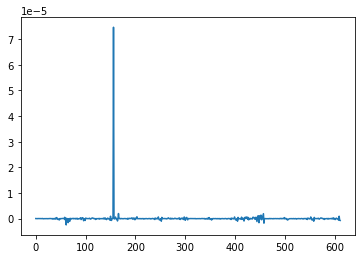

In [29]:
param_index = 1003
these_delays = np.array(first_derivative[param_index,:])
plt.plot(np.transpose(these_delays))
# print(these_delays.shape)

print(avg_first_derivative[param_index])

In [40]:
print(first_derivative[param_index, 156])
print(temperatures[param_index, 156])
print(pressures[param_index, 156])
print(phi_dicts[int(156 / 51)])

7.46232658910273e-05
770.64
1013250.0
{'O2(2)': 0.2038, 'butane(1)': 0.03135, 'N2': 0.7649, 'Ar': 0.0, 'CO2(7)': 0.0}


In [58]:
np.argmax(these_delays)

415

In [62]:
these_delays[0, 415]

nan

In [38]:
len(phi_dicts)

12

In [42]:
delta[0, :]

array([-0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20887562,
       -0.20887562, -0.20887562, -0.20887562, -0.20887562, -0.20

In [36]:
first_derivative[0, 415]

nan

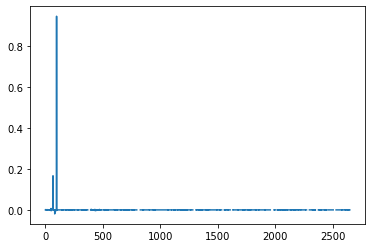

In [69]:
my_slice = total_delays[:, 156] - np.ravel(total_base_delays[:, 156])[:]

plt.plot(my_slice)

In [73]:
np.nanmax(my_slice)

0.9447936024934791

In [74]:
for i in range(0, 200):
    if my_slice[i] == np.nanmax(my_slice):
        print(i, my_slice[i])

97 0.9447936024934791


In [75]:
my_slice[97]

0.9447936024934791

In [66]:
my_slice.shape

(2653,)

In [67]:
total_delays[:, 156].shape

(2653,)

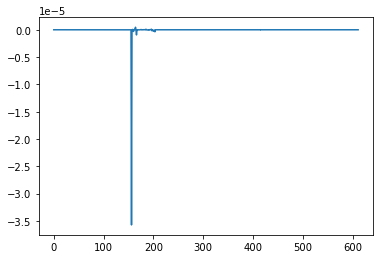

In [77]:
i = 0
plt.plot(np.ravel(first_derivative[i, :]))

In [78]:
first_derivative[0, 156]

-3.57334385504138e-05

## Get Improvement Score by Condition

In [116]:
# get improvement score at a particular condition:

condition_index = 382  # all top 10 are in top 50

condition_index = 415
# nothing at condition 415 worked

In [117]:
improvement_score.shape

(2653, 612)

In [118]:
single_improvement_score = np.ravel(improvement_score[:, condition_index])
single_improvement_score[np.isnan(single_improvement_score)] = -np.inf

In [119]:
parameter_indices = np.arange(0, N + M)
single_improvement_order = [x for _, x in sorted(zip(single_improvement_score, parameter_indices))][::-1]

print('Top Improvement Scores')
print('i\tDelta\tReaction\tSensitivity\tImprovement Score')
for i in range(0, 10):
    ct_index = single_improvement_order[i]
    
    if ct_index < N:
        print(ct_index, '\t', np.round(single_improvement_score[ct_index], 9),
              '\t', gas.species()[ct_index], )
    else:
        family = 'PDEP'
        try:
            family = reaction_list[ct2rmg_rxn[ct_index - N]].family
        except AttributeError:
            pass
        print(ct_index - N, '\t', np.round(single_improvement_score[ct_index], 9),
              '\t', gas.reactions()[ct_index - N], family)

Top Improvement Scores
i	Delta	Reaction	Sensitivity	Improvement Score
2522 	 -inf 	 O2(694) <=> O2(2) PDEP
2521 	 -inf 	 C3H5-A(94) + HO2(16) <=> C3H6(12) + O2(694) PDEP
2520 	 -inf 	 OH(15) + S(917) <=> C3H5O(70) + O2(694) PDEP
2519 	 -inf 	 C2H5O2(47) + CO(6) <=> C3H5O(70) + O2(694) PDEP
2518 	 -inf 	 S(911) <=> C3H5O(70) + O2(694) PDEP
2517 	 -inf 	 C3H5O3(72) <=> C3H5O(70) + O2(694) PDEP
2516 	 -inf 	 HO2(16) + O(5) <=> O2(694) + OH(15) Birad_R_Recombination
2515 	 -inf 	 O2(2) + OH(15) <=> O2(694) + OH(15) R_Recombination
2514 	 -inf 	 C2H2(25) + CH2CO(24) <=> C2H(4) + CH2CHO(21) PDEP
2513 	 -inf 	 C2H2(25) + CH2CO(24) <=> C2H3(22) + HCCO(27) PDEP


In [132]:
top20 = set()

# check that all top 10 in the single condition scenario are in the top 50 for the average
for condition_index in range(improvement_score.shape[1]):
    single_improvement_score = np.ravel(improvement_score[:, condition_index])
    single_improvement_score[np.isnan(single_improvement_score)] = -np.inf

    parameter_indices = np.arange(0, N + M)
    single_improvement_order = [x for _, x in sorted(zip(single_improvement_score, parameter_indices))][::-1]

#     print(condition_index)
    if condition_index == 415:
        continue
    for i in range(0, 20):
        ct_index = single_improvement_order[i]
        if ct_index not in improvement_order[0:50]:
            top20.add(ct_index)
            print(condition_index, ':\t', ct_index, 'mising!!!!!!!!!!!!!!!!!!')

    


51 :	 1486 mising!!!!!!!!!!!!!!!!!!
71 :	 991 mising!!!!!!!!!!!!!!!!!!
72 :	 991 mising!!!!!!!!!!!!!!!!!!
73 :	 991 mising!!!!!!!!!!!!!!!!!!
102 :	 1486 mising!!!!!!!!!!!!!!!!!!
102 :	 1002 mising!!!!!!!!!!!!!!!!!!
102 :	 997 mising!!!!!!!!!!!!!!!!!!
103 :	 1486 mising!!!!!!!!!!!!!!!!!!
103 :	 1002 mising!!!!!!!!!!!!!!!!!!
104 :	 1486 mising!!!!!!!!!!!!!!!!!!
104 :	 1002 mising!!!!!!!!!!!!!!!!!!
124 :	 991 mising!!!!!!!!!!!!!!!!!!
125 :	 991 mising!!!!!!!!!!!!!!!!!!
126 :	 991 mising!!!!!!!!!!!!!!!!!!
127 :	 991 mising!!!!!!!!!!!!!!!!!!
128 :	 991 mising!!!!!!!!!!!!!!!!!!
204 :	 1486 mising!!!!!!!!!!!!!!!!!!
224 :	 991 mising!!!!!!!!!!!!!!!!!!
225 :	 991 mising!!!!!!!!!!!!!!!!!!
226 :	 991 mising!!!!!!!!!!!!!!!!!!
255 :	 1486 mising!!!!!!!!!!!!!!!!!!
255 :	 1002 mising!!!!!!!!!!!!!!!!!!
255 :	 997 mising!!!!!!!!!!!!!!!!!!
256 :	 1486 mising!!!!!!!!!!!!!!!!!!
256 :	 1002 mising!!!!!!!!!!!!!!!!!!
257 :	 1486 mising!!!!!!!!!!!!!!!!!!
257 :	 1002 mising!!!!!!!!!!!!!!!!!!
277 :	 991 mising!

In [134]:
print(top20)

{1002, 997, 1486, 991}


In [131]:
len(top20)

1

In [ ]:
# condition 415. says we should include 2643-2652

In [106]:
improvement_score[2643, 415]

-inf

In [137]:
improvement_score[:, 415]

matrix([[-inf],
        [-inf],
        [-inf],
        ...,
        [-inf],
        [-inf],
        [-inf]])

In [148]:
rxns2calc = set()
improvement_threshold = 2e-7
for i in range(N + M):
    if np.any(np.ravel(improvement_score[i, :]) > improvement_threshold):
        rxns2calc.add(i)
    
print(rxns2calc)

{1027, 1924, 906, 523, 524, 907, 1680, 1936, 1816, 1823, 1445, 1446, 2599, 2601, 2602, 2476, 1073, 1841, 1843, 564, 1972, 2482, 951, 952, 953, 2486, 573, 574, 958, 576, 1089, 1484, 1879, 476, 735, 736, 991, 99, 739, 613, 102, 742, 744, 361, 362, 872, 1001, 1256, 1261, 1894, 2413, 881, 882, 884, 1268, 1269, 887, 1919}


In [149]:
for i in rxns2calc:
    if i not in improvement_order[0:50]:
        print(i)

1027
1936
2601
574
1484
991
739
742


In [147]:
print(len(rxns2calc))

237


In [ ]:
improvement

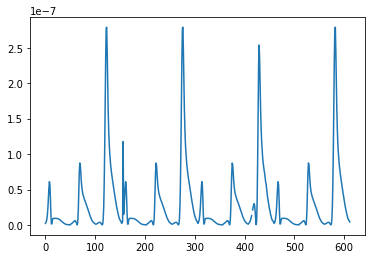

In [151]:
plt.plot(np.ravel(improvement_score[991,:]))